# Configuração

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST
In this chapter, we will use MNIST for classification. MNIST is a dataset comprised of 70,000 small images that represent handwritten digits by students & employees from the US census Bureau). Each image is labeled with the digit it represents (ranging from 0 to 9).

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X, y = X[:35000], y[:35000]
X.shape, y.shape

((35000, 784), (35000,))

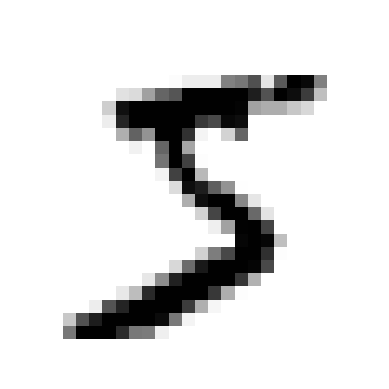

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

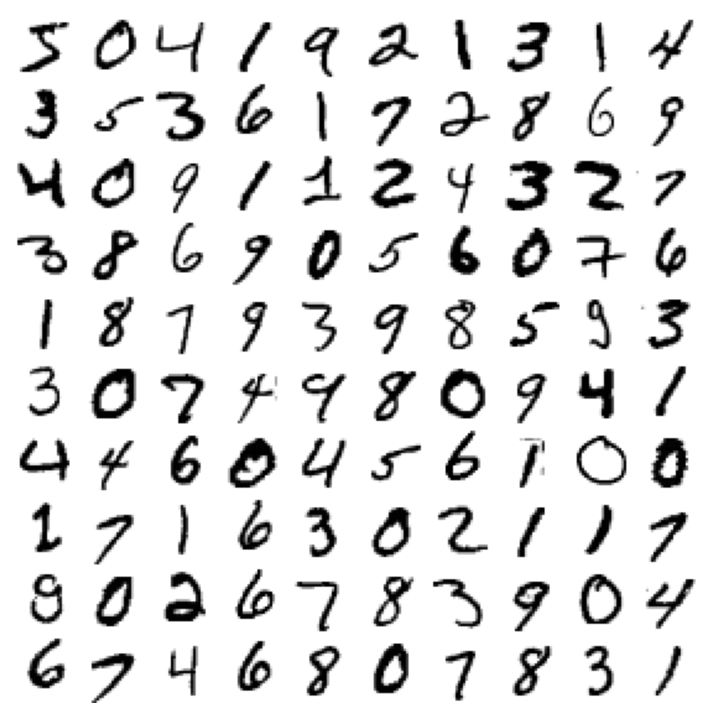

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:30000], X[30000:], y[:30000], y[30000:]

# Training a Binary Classifier
Let's simplify the problem for now and try to identify one digit (number 5). This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.

Let's create the target vector for the classification task:

Let's take a fraction of the training data for the notebook to run fast locally:

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

A good place to start is with a Stochastic Gradient Descent Classifier:

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

In [14]:
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

In [15]:
sgd_clf.predict(X=[some_digit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9458, 0.9634, 0.9603])

# Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available.

## Measuring Accuracy using Cross Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.9481
0.9659
0.9655


Above 95% accuracy, isn't that great?

Let's look at the performance of a very dumb classifier that classifies all training rows as "Not-5":

In [20]:
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [22]:
never_5_classifier = Never5Classifier()

In [23]:
scores = cross_val_score(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=5, scoring="accuracy", n_jobs=-1)
scores

array([0.91433333, 0.911     , 0.91016667, 0.90716667, 0.90583333])



The dumb classifier has over 90% acccuracy for any validation. This happened because of the class imabalance in the binary task we are aiming for.

We originally had balanced counts for each digit. But when we turned the problem into 5 vs. non-5, we ended up with the first class taking ~10% of the rows and non-5 taking >=90%. Hence, if we create a dumb model that just predicts "non-5" for any input, you'll get at least 90% accuracy.

This demonstrates why accuracy is generally not the preferred method to evaluate classifiers, especially if the data have imbalanced classes.


## Confusion matrix

A much better way to evaluate the performance of a classifier is to look at its produced confusion matrix.

Let's use cross_val_predict() to get some predictions to finally visualize the confusion matrix:

In [24]:
from sklearn.model_selection import cross_val_predict


In [25]:
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs=-1)

In [26]:
y_train_pred.shape

(30000,)

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[26515,   776],
       [  529,  2180]])


Each row in the confusion matrix represents an actual class. While each column represents a predicted class.
* first row is "not 5": Model correctly predicted "not 5" for 26K "not 5"s (True Negatives).
* Model incorrectly predicted "5" for 776 "not 5"s (False Positives).
* second row is "5": Model incorrectly predicted "not 5" for 529 "5"s (False Negative)
* Model correctly predicted "5" for 2180 "5"s (True Positives)

A perfect classifier would have only True Positives and True negatives, meaning the confusion matrix will have zeros on all elements except its diagonal.

Let's pretend we reached perfection:


In [29]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[27291,     0],
       [    0,  2709]])

![confusion-matrix](./images/classification/confusion_matrix.png)

# Precision and Recal

The confusion matrix gives us a lot of information, but sometimes you may prefer a single-number metric.

An interesting one to look at is the model's accuracy over its positive predictions, named precision:

$$ precision = \frac{TP}{TP + FP} $$

Precision is the how many P class is correct classified over how many model says is P class.

A trivial way to have a perfect precision of 1 is to make one prediction that you're sure it's correct, by consequence $FP=0$ and $precision=1$. This would not be useful since the evaluation is ignore all but the true positives.

Precision is typically used along with another metric named recall.

Recall, also called sensitivity or the True Positive rate is as follows:

$$recall = \frac{TP}{TP + FN} $$

Recall is the how many P class is corrected classified over how many model should classify as P class.



In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
precision_score(y_true=y_train_5, y_pred=y_train_pred)

0.7374830852503383

In [32]:

recall_score(y_true=y_train_5, y_pred=y_train_pred)

0.8047249907715024

In [33]:
y_train_never5_pred = cross_val_predict(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=3, n_jobs=-1)

In [34]:
precision_score(y_true=y_train_5, y_pred=y_train_never5_pred)

/home/wesin/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [35]:
recall_score(y_true=y_train_5, y_pred=y_train_never5_pred)

0.0

The recall score is not good at all.
Its dominator consists of TPs & False Negatives. We can conclude that our model is predicting a lot of digits as not "5" but they're "5"s. The model is not good at predicting False Negatives.

Now our model doesn't look as shiny as it was when we looked at its accuracy. When it claims that a digit represents a "5" it's only correct for  $80%$ of the times.

It's often convinient to combine the precision and accuracy scores into a single metric called the $F_1$ score. In particular, if we want to compare two classifiers.

The $F_1$ score represents the harmonic mean of the precision & recall metrics. It is harmonic because it gives more importance to low values in its formula.

Meaning, the $F_1$ score will only give you high scores if both precision and recall are high.

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall}$$





In [36]:
from sklearn.metrics import f1_score

In [37]:
f1_score(y_true=y_train_5, y_pred=y_train_pred)

0.7696381288614299

The $F_1$ favors classifiers that have similar precision and recall. But this is not always what we would want:

Sometimes we only care about precision (the relation between True Positives and False Positives). Ex: we don't want to incorrectly predict that a bad video is safe for kids to watch, but you don't care that much if you incorrectly predict that a video is bad.

Other times we only care about recall (the relation between True Positives and False Negatives). Ex: we don't want to incorrectly predict that a person doesn't have cancer.

Unfortunately, we can't have it both ways, increasing precision will decrease recall, and increasing recall decreases precision.

This is called the precision-recall trade-off.

## Precision-Recall Trade-off

To understand this trade-off, we need to know how the algorithm is making its decisions.

For each instance, the classifier outputs a score (we can call it a probability), if the score is higher than a certain threshold, we label the instance as positive (a "5"), but if the score is less than the threshold, we the instance as negative (a "not 5")

![precision-recall-tradeoff](https://nbviewer.org/github/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/static/imgs/precision-recall-trade.png)

As we can see, if we raise the threshold, precision converges to 100, but as a result, we lower the recall. Same happens to recall if we lower the threshold, we get a better recall (False Negatives are fewer) but we decrease precision.

Scikit-learn doesn't allow us to set the threshold directly, but it can give us the scores for each of its prediction.

We can set the threshold we want after getting the scores:

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([11968.30313346])

In [39]:
threshold = 0

In [40]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [41]:
threshold = 8000

In [42]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [43]:
y_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, 
                             cv=3, method='decision_function', n_jobs=-1)

In [44]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()

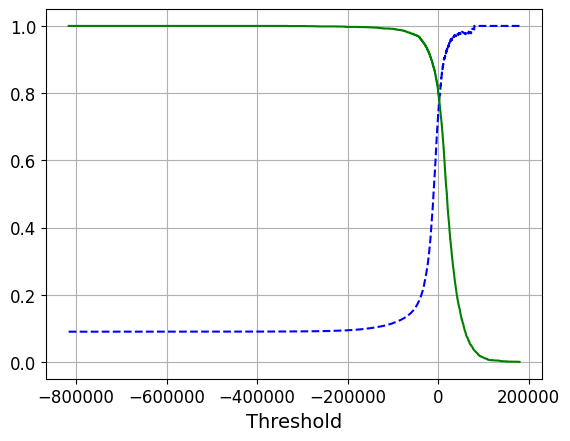

In [46]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()


We may wonder why the precision curve is bumpier than the recall curve. The reason is that the precision may sometimes go down when we raise the threshold. We may lose precision by upping the threshold if we lose TPs while the FPs are still there, but generally, precision should increase.

On the other hand, recall is very smooth because we add another TN while moving the threshold, nothing changes in the score.

Another way to select a good precision and recall trade-off is to plot precision directly against recall:


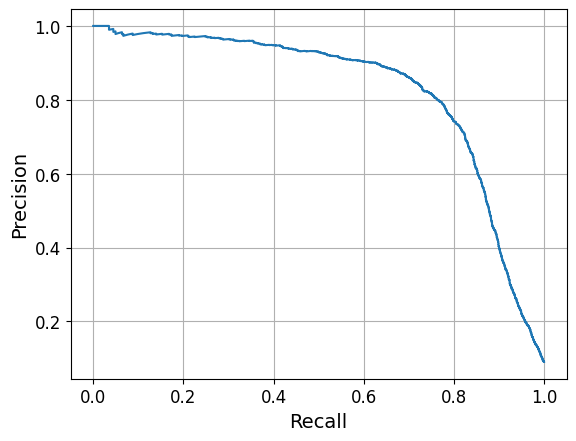

In [47]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

We can see the precision really starts to fall sharply around 80% recall.

We would probably want to select a precision/recall trade-off just before that drop (For example, at around 60% recall). But ofcoures, the choice depends on the project.

Suppose we want to aim for 90%
precision, we would look up the first graph to get the threshold and lookup the second graph to find the best Recall we can get with a precision of 90%

Implementation: let's search for the lowest threshold that give at least 90%
precision score:

In [48]:
threshold_90_precision = thresholds[np.argmax(precision > .9)]
threshold_90_precision

12605.39256572511

In [49]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [50]:
precision = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
precision

0.9003181336161188

In [51]:
recall = recall_score(y_train_5, y_train_pred_90)
recall

0.6267995570321152

We should remember that a high precision classifier is not good at all with a low recall.

If someone shouts: "Let's reach a 99% precision score", you should ask: "But at what Recall?"|

## ROC Curve
The receiver operating characteristic curve is another tool used with binary classifiers. ROC plots TP rate versus FP rate.

ROC plots recall versus 1 - specificity

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, thresholds = roc_curve(y_true=y_train_5, y_score=y_scores)

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

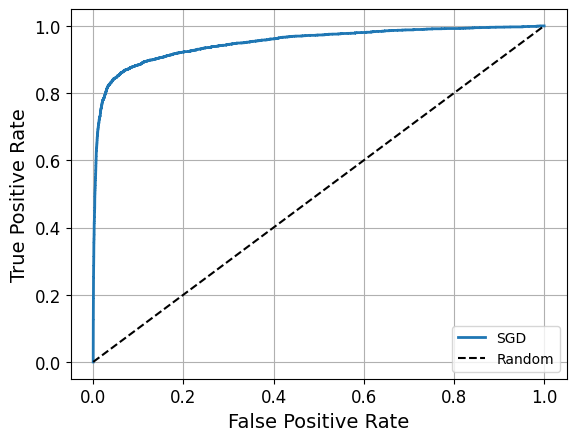

In [55]:
plot_roc_curve(fpr, tpr, label='SGD')
plt.legend(loc='lower right')
plt.show()

The Higher the recall, the more false positives the model produces.

The dotted line represent the ROC curve of a completely random classifier. A good classifier stays as far a way as possible from the dotted line.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an ROC AUC of 1 and a purely random classifier will have an ROC AUC of 0.5.

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9509867800410808

Let's now train a RandomForestClassifier to compare its ROC Curve and ROC AUC score to the SGDClassifier's:

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                    y=y_train_5, cv=5, 
                                    n_jobs=-1, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]  # P(X=5)
fpr_forest, tps_forest, threshs_forest = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

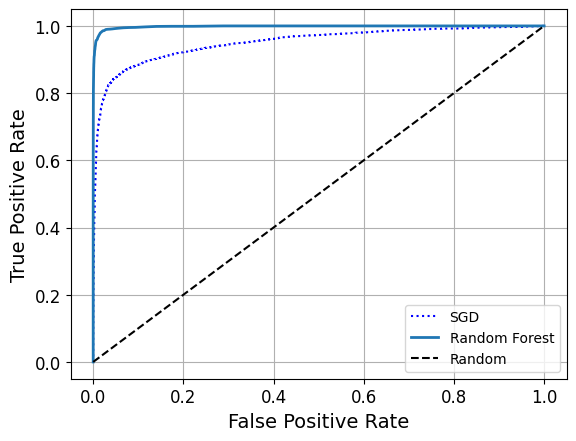

In [58]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tps_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()


In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.998160698309738

In [60]:
y_preds_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                   y=y_train_5, cv=5, 
                                   n_jobs=-1)


In [61]:
precision_score(y_true=y_train_5, y_pred=y_preds_forest)

0.989659629470056

We now know how to ...
* train classifiers
* choose the appropriate metric for the task
* evaluate the classifier using cross-validation
* select the precision-recall ratio that fits the needs
* use ROC and ROC AUC to compare various models

Time to move to multiclass classification (beyond binary classification):


# Multiclass Classification

There are techniques we can use to perform multiclass classification with binary classifiers. One way to create a system that can classify an image into 10 labels (from 0 to 9) is to train 10 binary classifiers (one for each digit).

Then when we want to classify an image, we get each classifier's associated positive score and pick the model class w/ the highest score. This is called one-versus-the-rest startegy, or 1-vs-all.

Another startegy is to train a binary classifier for each pair of digits. This is called 1-vs-1. If there are N classes, we would need to train $\frac{N\times(N-1)}{2}$. For the MNIST Problem, this means training 45 binary classifiers. The class which wins the most duals is the predicted one.

Even though we need to create many classifiers, they are needed to be trained on only the data points where one of the classes appeared.

Scikit-learn detects when we try to use a binary classification algorithm for a multiclass classification problem, it then automatically use OvO or OvR depending on the algorithm to train.

In [62]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC()
svm_clf.fit(X=X_train, y=y_train)

/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [63]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In this case, the Support Vector Classifier used OvO to predict the class of some_digit. It tried $N∗(N−1)/2$

classifier for all pairs of classes.

After inputing a new sample, it runs all 45 trained models and picks the one who won the most duals.

If we inspect the score for a specific instance input, we will notice that the model outputs 10 scores, for each digit. Giving us a performance measure of each digit versus all others.

In [64]:
some_digit_scores = svm_clf.decision_function(X=[some_digit])
some_digit_scores

array([[-3.28847514e+00, -8.06314630e+00, -2.46615031e+00,
        -6.68795132e-03, -6.01626826e+00,  2.21179381e-02,
        -5.84041930e+00, -5.63203810e+00, -1.95802826e+00,
        -1.67659876e+00]])

In [65]:
np.argmax(some_digit_scores)

5

In [66]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

If we want to force the algorithms to follow a particular startegy, OvO or OvR for example:

In [68]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

ovr_clf.fit(X=X_train, y=y_train)

/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to 

OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [69]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [70]:
len(ovr_clf.estimators_)

10

SGD or Random Forest Classifiers can directly classify an instance into multiple classes:

In [71]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X=X_train, y=y_train)

SGDClassifier(n_jobs=-1, random_state=42)

In [72]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [73]:
sgd_clf.decision_function([some_digit])

array([[ -50458.5075631 , -136486.63842062,  -14135.49961456,
         -10399.0572803 ,  -63068.57630296,   -3043.28005489,
         -64103.92249307,  -68757.6494235 ,  -44670.30230201,
         -27252.81246434]])

In [74]:
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)

array([0.88366667, 0.864     , 0.86916667, 0.87766667, 0.8725    ])

It gets over 84% over all test folds.

If we use a random classifier, we would get 10% accuracy, so 80% isn't that bad. However, by simply scaling the input we can push accuracy to over 86%:

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X=X_train.astype(np.float64))
cross_val_score(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)

/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.908     , 0.90266667, 0.89116667, 0.90283333, 0.90733333])

## Error Analysis

Here, we will assume that we have found a promissing model and that we want to improve it. One of the few ways is to analyze the types of errors it makes.

First, let's look at the confusion matrix:

In [76]:
y_train_predict = cross_val_predict(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=5, n_jobs=-1)
conf_mtrx = confusion_matrix(y_true=y_train, y_pred=y_train_predict)
conf_mtrx

/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/wesin/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[2806,    0,   15,    3,    4,   30,   18,    2,   83,    0],
       [   1, 3252,   24,   13,    3,   28,    2,    3,   91,    6],
       [  14,   18, 2572,   62,   39,   15,   36,   21,  165,    6],
       [  12,   15,   68, 2651,    2,   96,   12,   26,  153,   38],
       [   9,    7,   25,    6, 2622,    4,   20,    8,  129,   96],
       [  15,   12,   18,   80,   41, 2261,   35,    6,  202,   39],
       [  17,    6,   20,    0,   21,   48, 2801,    5,   57,    0],
       [  10,    2,   31,   15,   27,    3,    3, 2821,   59,  136],
       [   6,   34,   21,   53,    2,   59,   21,    3, 2651,   25],
       [  18,   13,   16,   31,   62,   15,    1,   88,  124, 2635]])

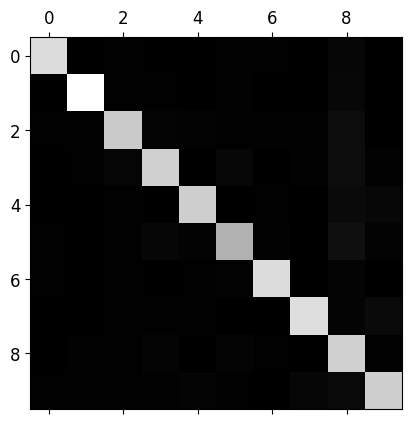

In [77]:
plt.matshow(A=conf_mtrx, cmap=plt.cm.gray)
plt.show()

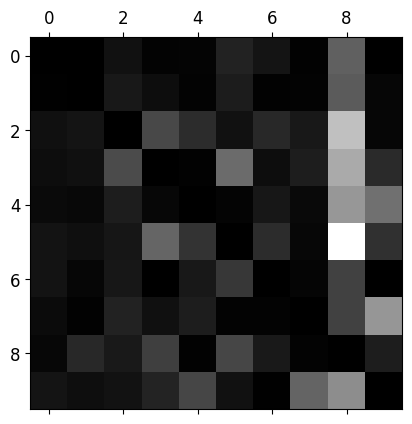

In [78]:
row_sums = conf_mtrx.sum(axis=1, keepdims=True)
normed_conf_mtrx = conf_mtrx / row_sums
np.fill_diagonal(normed_conf_mtrx, 0)
plt.matshow(A=normed_conf_mtrx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kind of errors the classifier makes. Remember that the rows represent acutal labels and the columns represent the predicted class.

The column of class 8 is quite bright, which tells us that many input images get misclassified as 8s. However, the row for 8s is not that bad, telling us that when given input images of 8s, the model does a good job of classifying them as 8s.

As we can see, the confusion matrix is not necessarly symmetrical. In our specific example, 3s and 5s are often confused.

Analyzing the confusion matrix often gives us insights into how to improve the classifier itself.

Looking at this plot, it seems that our efforts should be focused on reducing the false 8s. For example, we could try collecting images of digits that look like 8s but are not, then training the classifier to better distinguish.

Analyzing our errors could be also a good way into knowing what the model is learning and why is it failling.


In [79]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_predict == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_predict == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_predict == cl_b)]

In [80]:
from math import ceil

In [83]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots digits on a grid of rows and columns."""
    size = 28
    n_images = instances.shape[0]
    images_per_row = min(n_images, images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = ceil(n_images / images_per_row)
    row_images = []
    n_empty = n_rows * images_per_row - n_images
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

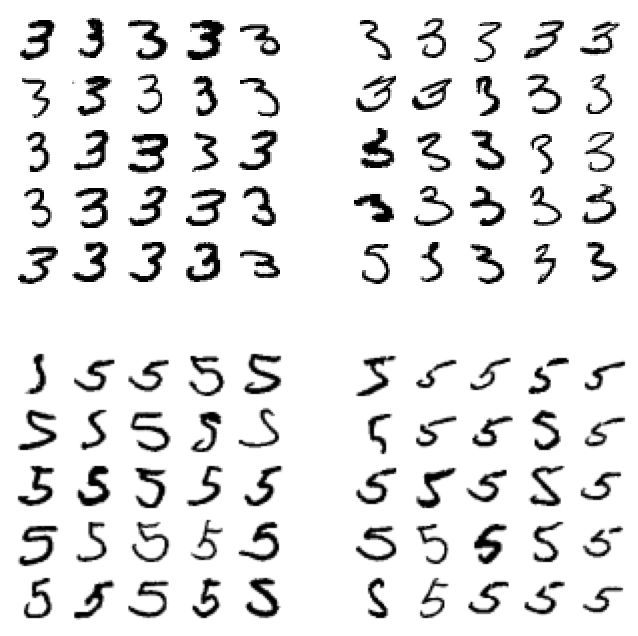

In [84]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show instances classified as 3s, and the two 5x5 blocks on the right show instances classified as 5s.

Most misclassifed images seem like obvious mistakes to us and it's hard for us to understand why the classifier made the mistakes it did.

The true reason is that when we used SGDClassifier, which is a linear model, it just assigns weights to each pixel, and when it gets a new image, it sums up the pixel intensities times the trained weights, and since 5s and 3s share most of the pixel intensity locations, the model get sometimes confused.

The main difference between a 5 and a 3 is the position of the small line that joins the top line to the bottom arc.

Meaning that if we draw a 3 with a slightly shifted line to the left, the classifier might assign it a 5, and same to 5s classified as 3s.

In other words, this classifier is quite sensitive to image rotation and shifting. So one way to reduce errors is to preprocess the images to make sure the digits are well centered and not too rotated.

# Multilabel Classification
In some cases, we want our classifier to output multiple classes per instance (e.g. Face recognition in images).

What should it do when it recognizes several people in a picture?

Such system that outputs multiple binary scores that don't necessarly sum up to 1 is called a multilabel classifier.

Let's go through a simple example:

In [85]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X=X_train, y=y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

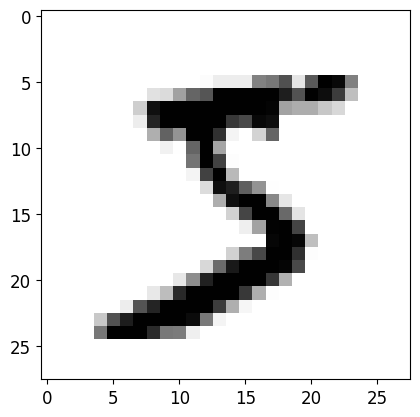

In [86]:
plt.imshow(some_digit.reshape(28, 28), cmap='binary')

Got it right! 5 is indeed less than 7 and odd.

There are many ways to evaluate a multilabel classifier, selecting the best metrics will depend on the project. One approach is to simply calculate F1
score for each label category, then average all scores into one number:

In [87]:
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(estimator=knn_clf, X=X_train, y=y_multilabel, cv=5, n_jobs=-1)
score = f1_score(y_multilabel, y_train_knn_pred, average="macro")
score

0.9720267778020544

This assumes that all label categories are equally important, which may not be true. In particular, if we have more pictures of alice than bob we may want to give more weight to bob pics in evaluation. This is called unbalanced classes within a label category.

One simple way to do it is to give each class a score corresponding to it support. The less samples we have of bob, the more important one score of him is.

# Multioutput Classification
The last type of classification we will discuss is called multioutput-multiclass classification (Ex. Identifying animals in a picture & for each animal we have N classes). Meaning, each label can be multiclass.

To demonstrate this, let's build a system that removes noise from images. It will take the noisy digit images as input, and will hopefully output an image that look like the original one from the dataset. Notice that the system is a multioutput classification one (Output: 728 pixels, each pixel intensity ranges from 0 to 255).

Let's start with training data by adding a mask of noise, the original image will serve as the output (target):

In [88]:
noise = np.random.randint(low=0, high=100, size=(X_train.shape[0], 784))
X_train_mod = X_train + noise
X_train_mod.shape

(30000, 784)

In [89]:
noise = np.random.randint(low=0, high=100, size=(X_test.shape[0], 784))
X_test_mod = X_test + noise
X_test_mod.shape

(5000, 784)

In [90]:
y_train_mod = X_train.copy()
y_test_mod = X_test.copy()

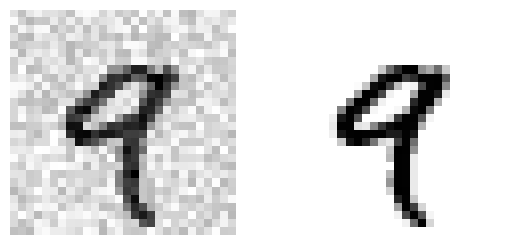

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')
ax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

In [92]:
knn_clf.fit(X=X_train_mod, y=y_train_mod)

KNeighborsClassifier(n_jobs=-1)

In [93]:
clean_digit = knn_clf.predict(X=[X_test_mod[234]]).reshape(28, 28)

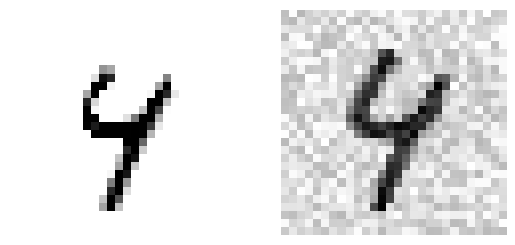

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(clean_digit, cmap='binary'); ax[0].axis('off')
ax[1].imshow(X_test_mod[234].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()